In [1]:
# import sys
# sys.path.append('..')

In [2]:
from utility import load_dataset, load_model_with_ckpt, make_segments_and_graph
import draw_utils

/opt/miniconda3/envs/yrchen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision.transforms as VT

In [4]:
import os
from PIL import Image
import numpy as np

import sys
sys.path.append('..')
print(sys.path)
from cnn_dataset.mnistm import MNISTM

DATA_DIR = '~/data/'
ORIGIN_DATA_DIR = DATA_DIR + 'mnist_m/'
ori_dataset = MNISTM(ORIGIN_DATA_DIR, mode='test')

dataset = load_dataset('mnist_m', train=False)

['/home/dragonchen/SPGIE_thesis/explainer', '/opt/miniconda3/envs/yrchen/lib/python310.zip', '/opt/miniconda3/envs/yrchen/lib/python3.10', '/opt/miniconda3/envs/yrchen/lib/python3.10/lib-dynload', '', '/opt/miniconda3/envs/yrchen/lib/python3.10/site-packages', '/opt/miniconda3/envs/yrchen/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '..', '..']
----- Loading test dataset -----


In [5]:
# hidden_dim = 20
# ckpt_name = '/home/dragonchen/mlruns/0/c02d833566014cb0877882980a24f7f7/artifacts/best.pt'
hidden_dim = 64
ckpt_name = '/home/dragonchen/mlruns/0/b6c409724cbc4c6da8f703344d56dc58/artifacts/best.pt'
# hidden_dim = 128
# ckpt_name = '/home/dragonchen/mlruns/0/843a07bea5794a3787f90b9356395c43/artifacts/best.pt'
# hidden_dim = 256
# ckpt_name = '/home/dragonchen/mlruns/0/e367774683fa4f3e9e69e439b7aaf318/artifacts/best.pt'

aggr = 'add'
pool = 'max'

device = torch.device('cpu')
model = load_model_with_ckpt(
    input_dim=dataset.num_features,
    hidden_dim=hidden_dim,
    output_dim=dataset.num_classes,
    drn_k=4, aggr=aggr, pool=pool,
    device=device,
    ckpt_name=ckpt_name,
)

Pooling with max
Using self-loops
There are 2 aggregation layers


In [6]:
evaluate_on_testset = False

if evaluate_on_testset:
    import sys
    sys.path.append('..')
    from models.graph_phase import test
    from torch_geometric.loader import DataLoader

    # test_dev = torch.device('cuda:0')
    test_dev = torch.device('cpu')
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    acc, _ = test(model.to(test_dev), loader, device=test_dev, mlflow_log=False)
    print(f'Got {acc * 100:.2f}% acc on testing set.')
    model = model.to(device)

In [7]:
img_idx = 11
img_ori, lbl = ori_dataset[img_idx]
# img_ori, lbl = MNISTM(ORIGIN_DATA_DIR, mode='train')[img_idx]
img_sp, segments, node2map = make_segments_and_graph(
    torch.permute(img_ori, (1, 2, 0)), channel_axis=2,
)
img_sp.y = torch.tensor(lbl)

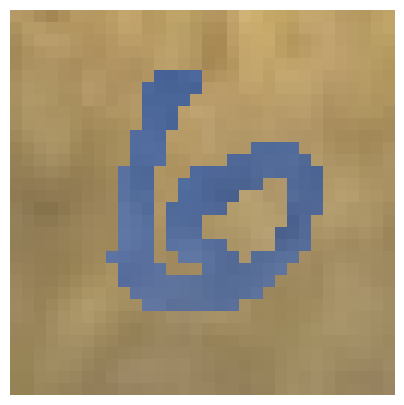

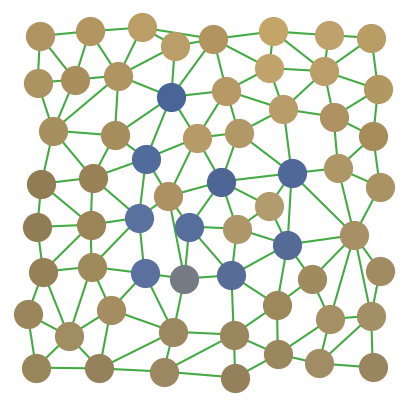

In [8]:
import matplotlib.pyplot as plt

# original
draw_utils.show_original(img_ori)

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2:],
    img_sp.edge_index,
)
plt.show()

In [9]:
img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
img_sp = img_sp.to(device)

out = model(img_sp).detach().cpu()

print('true', lbl)
print('pred', out.argmax(1).item())

true 6
pred 6


In [10]:
# torch.manual_seed(1340)
for i, c in enumerate(torch.softmax(out, 1).tolist()[0]):
    print(f'{i} {c:.04f}')

0 0.0000
1 0.0000
2 0.0001
3 0.0000
4 0.0005
5 0.0001
6 0.9982
7 0.0000
8 0.0012
9 0.0000


## Load CNN Model

In [11]:
use_cuda = True

In [12]:
from torchinfo import summary
from torchvision import models
import sys
sys.path.append('..')
from models import resnet

if use_cuda:
    device2 = torch.device('cuda:1')
else:
    device2 = torch.device('cpu')

# cnn model
model_name = 'resnet'

def load_state_dict(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device2)
    model.load_state_dict(ckpt)

if model_name == 'lenet':
    cnn_model = LeNet.lenet()
#     ckpt_name = 'lenet_e60_test9920.pt'
#     ckpt_name = 'lenet_hs_e80_test8702.pt'
    ckpt_name = 'lenet_e120_9284.pt'
elif model_name == 'resnext':
    cnn_model = resnet.resnext50_32x4d()
#     ckpt_name = 'resnext_e40_test9900.pt'
#     ckpt_name = 'resnext_e60_test9886.pt'
    ckpt_name = 'resnext_hs_e20_test9876.pt'
elif model_name == 'resnet':
    cnn_model = resnet.resnet50()
#     ckpt_name = 'resnet_e40_test9873.pt'
#     ckpt_name = 'resnet_e60_test9864.pt'
#     ckpt_name = 'resnet_hs_e40_test9912.pt'
    ckpt_name = 'resnet_hs_e60_test9912.pt'

ckpt_folder = '../ckpts/cnnckpt_resnet/'
load_state_dict(cnn_model, ckpt_folder + ckpt_name)

cnn_model = cnn_model.to(device2)
cnn_model.eval()
summary(cnn_model, input_size=(1, 3, 32, 32), depth=2, device=device2)

Layer (type:depth-idx)                   Output Shape              Param #
ResNetOriginal                           [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 256, 32, 32]          --
│    └─BottleNeck: 2-4                   [1, 256, 32, 32]          75,008
│    └─BottleNeck: 2-5                   [1, 256, 32, 32]          70,400
│    └─BottleNeck: 2-6                   [1, 256, 32, 32]          70,400
├─Sequential: 1-3                        [1, 512, 16, 16]          --
│    └─BottleNeck: 2-7                   [1, 512, 16, 16]          379,392
│    └─BottleNeck: 2-8                   [1, 512, 16, 16]          280,064
│    └─BottleNeck: 2-9                   [1, 512, 16, 16]  

In [13]:
out = cnn_model(img_ori.to(device2).unsqueeze(dim=0))
print('label', lbl)
print('CNN predict', out.argmax(dim=1).detach().item())

label 6
CNN predict 6


## Start Explaining

In [14]:
from models.jit_drn_model import (
    knn_graph, to_undirected, normalized_cut_2d,
    graclus_cluster,
    global_pool_aggr,
)
from torch_scatter import scatter
from torch_geometric.typing import OptTensor, Optional, Tuple
from torch import Tensor
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool.pool import pool_batch
import torch

verbose = False

# def consecutive_cluster(src):
#     unique, inv = torch.unique(src, sorted=True, return_inverse=True)
#     perm = torch.arange(inv.size(0), dtype=inv.dtype, device=inv.device)
#     perm = inv.new_empty(unique.size(0)).scatter_(0, inv, perm)
#     return inv, perm

def _aggr_pool_x(cluster, x, aggr: str, size: Optional[int] = None):
    """Call into scatter with configurable reduction op"""
    return scatter(x, cluster, dim=0, dim_size=size, reduce=aggr)

def global_pool_aggr(x, batch: OptTensor, aggr: str, size: Optional[int] = None):
    """Global pool via passed aggregator: 'mean', 'add', 'max'"""
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if batch is not None:
        size = int(batch.max().item() + 1)
    assert batch is not None
    return scatter(x, batch, dim=0, dim_size=size, reduce=aggr)

# this function is specialized compared to the more general non-jittable version
# in particular edge_attr can be removed since it is always None
def aggr_pool(cluster, x, batch: OptTensor, aggr: str) -> Tuple[Tensor, OptTensor]:
    """jit-friendly version of max/mean/add pool"""
#     print('c1', cluster.shape)
#     print(cluster[:20])
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    
    cluster_data = {
        'c1': c1,
        'c2': cluster.detach().cpu(),
        'p': perm.detach().cpu(),
    }

    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)
    return x, batch, cluster_data

def aggr_pool_x(cluster, x, batch: OptTensor, aggr: str, size: Optional[int] = None) -> Tuple[Tensor, OptTensor]:
    """*_pool_x with configurable aggr method"""
    global node_hist
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if size is not None and batch is not None:
        batch_size = int(batch.max().item()) + 1
        return _aggr_pool_x(cluster, x, aggr, batch_size * size), None

    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)

    cluster_data = {
        'c1': c1,
        'c2': cluster.detach().cpu(),
        'p': perm.detach().cpu(),
    }
    
    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)

    return x, batch, cluster_data

In [15]:
def get_explanation(model, data):
    node_hist = []
    
    drn = model.drn
    x = data.x
    batch = data.batch
    
    x = drn.datanorm * x
    x = drn.inputnet(x)

    nAgg = len(drn.agg_layers)

    node_hist.append({'x': x.detach().cpu()})
    for i, edgeconv in enumerate(drn.agg_layers):
        knn = knn_graph(x, drn.k, batch, loop=drn.loop, flow=edgeconv.flow)
        edge_index = to_undirected(knn)
        x = edgeconv(x, edge_index)
        
        weight = normalized_cut_2d(edge_index, x)
        cluster = graclus_cluster(edge_index[0], edge_index[1], weight, x.size(0))

        if i == nAgg - 1:
            x, batch, cluster_data = aggr_pool_x(cluster, x, batch, drn.aggr_type)
        else:
            x, batch, cluster_data = aggr_pool(cluster, x, batch, drn.aggr_type)

        node_hist.append(cluster_data)
            
        xx = data.x.cpu()
        ee = edge_index.cpu()
        node_hist.append({'x': x.detach().cpu()})

    x = global_pool_aggr(x, batch, drn.aggr_type)
    node_hist.append({'global_x': x.detach().cpu()})
    
    return node_hist

from collections import defaultdict
def parse_node_l1(
    node_hist,
    gx_threshold=1, counter_threshold=1,
    verbose=False,
    smooth=False, smooth_thresholds=None,
):
    counter = defaultdict(int)
    gx = node_hist[-1]['global_x']
    for i, g in enumerate(gx.tolist()[0]):
        if g > gx_threshold:
            xx2 = node_hist[-2]['x']
            xx2k = xx2[:, i].tolist().index(g)
            counter[xx2k] += 1
            
#     print(node_hist[1:-1:2])
    
    # setting
    l1 = node_hist[1]
    l2 = node_hist[3]

    # set the threshold
    nodes_global = [n for n in counter if counter[n] >= counter_threshold]
    if smooth:
        cosine = torch.nn.CosineSimilarity(dim=0)
        x_l1 = node_hist[0]['x']
        x_l2 = node_hist[2]['x']

    # layer2
    cosine_hist = [[], []]
    nodes_l2 = []
    for n in nodes_global:
        idx = l2['p'][n].item() # put node-num get cluster idx
        c = l2['c2'][idx].item() # extract original node-num from cluster idx
        nodes = torch.arange(len(l2['c2']))[l2['c2'] == c].tolist()
        if smooth:
#             print('idx', idx, c)
            anchor = x_l2[idx]
#             print('l2', [cosine(anchor, x_l2[n]) for n in nodes])
            ch_l2 = [cosine(anchor, x_l2[n]).item() for n in nodes if n != idx]
            cosine_hist[0] += ch_l2
#             nodes = [n for n in nodes if cosine(anchor, x_l2[n]) >= smooth_thresholds[0]]

        nodes_l2 += nodes

    # layer1
    nodes_l1 = []
    for n in nodes_l2:
        idx = l1['p'][n].item() # put node-num get cluster idx
        c = l1['c2'][idx].item() # extract original node-num from cluster idx
        nodes = torch.arange(len(l1['c2']))[l1['c2'] == c].tolist()
        if smooth:
#             print('idx', idx, c)
            anchor = x_l1[idx]
#             print('l1', [cosine(anchor, x_l1[n]) for n in nodes])
            ch_l1 = [cosine(anchor, x_l1[n]).item() for n in nodes if n != idx]
            cosine_hist[1] += ch_l1
#             nodes = [n for n in nodes if cosine(anchor, x_l1[n]) >= smooth_thresholds[1]]

        nodes_l1 += nodes

    return nodes_l1, cosine_hist

In [16]:
def mask_with_spgie(img_ori, img_g, segments, lbl,
                    alpha=0.3,
                    gx_threshold=1, counter_threshold=1,
                    return_nodes=False,
                    smooth=False,
                    smooth_thresholds=None,
):
    num_nodes = np.max(segments) + 1
    node2map = {n: (segments == n) for n in range(num_nodes)}
    
    torch.manual_seed(1340)
    img_g.batch = torch.zeros(img_g.x.shape[0]).long()
    img_g = img_g.to(device)
    out = model(img_g).detach().cpu()
    
    node_hist = get_explanation(model, img_g)
    final_nodes, cosine_hist = parse_node_l1(
        node_hist,
        gx_threshold=gx_threshold, counter_threshold=counter_threshold,
        smooth=smooth, smooth_thresholds=smooth_thresholds,
    )
    
    # pixels version
    img_ori_temp = img_ori.numpy().copy()
    img_temp = img_ori_temp.copy() * alpha
    img_masked = img_temp.copy()

    for n in final_nodes:
        if n in node2map:
            m = node2map[n]
            img_masked[:, m] += img_ori_temp[:, m] * (1 - alpha)
            img_temp[0, m] += (1 - alpha)
        else:
            print('error in', n)
    if return_nodes:
        return img_masked, final_nodes, cosine_hist

    return img_masked


In [17]:
# # statistic of cosine distences
# cosine_hist = [[], []]
# from tqdm import tqdm
# for idx in tqdm(range(2000, 3000)):
#     img_ori, lbl = ori_dataset[idx]
#     # img_ori, lbl = MNISTM(ORIGIN_DATA_DIR, mode='train')[img_idx]
#     img_sp, segments, node2map = make_segments_and_graph(
#         torch.permute(img_ori, (1, 2, 0)), channel_axis=2,
#     )
#     img_sp.y = torch.tensor(lbl)
    
#     temp, nodes, ch = mask_with_spgie(
#         img_ori, img_sp, segments, lbl,
#         alpha=0.33,
#         return_nodes=True,
#         smooth=True, smooth_thresholds=[0, 0],
#     )
    
#     cosine_hist[0] += ch[0]
#     cosine_hist[1] += ch[1]
# #     draw_utils.show_original(temp)

# #     imp = [[0, 0, 0] for _ in range(img_sp.x.shape[0])]
# #     for n in nodes:
# #         imp[n][0] = 128

# #     draw_utils.draw_superpixel_from_graph(
# #         img_sp.pos, [img_sp.x[:, 2:], imp],
# #         img_sp.edge_index,
# #         multi_graph=True,
# #     )

100%|██████████| 1000/1000 [00:38<00:00, 25.82it/s]


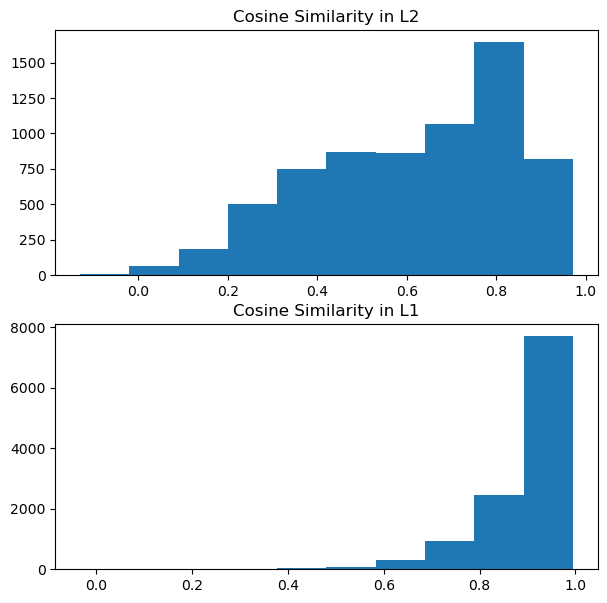

In [18]:
figures, axes = plt.subplots(2, 1, figsize=(7, 7))
axes[0].hist(cosine_hist[0])
# axes[0].set_xlim(0, 1)
axes[0].title.set_text('Cosine Similarity in L2')
axes[1].hist(cosine_hist[1])
axes[1].title.set_text('Cosine Similarity in L1')
# axes[1].set_xlim(0, 1)
# plt.show()
plt.savefig('cosine_Similarity.pdf')

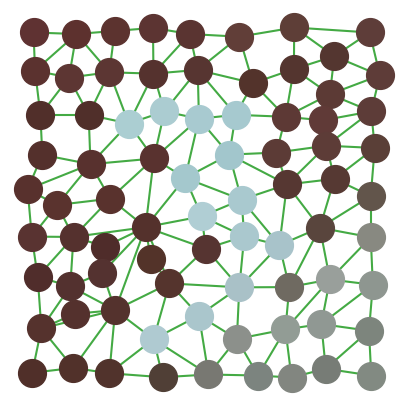

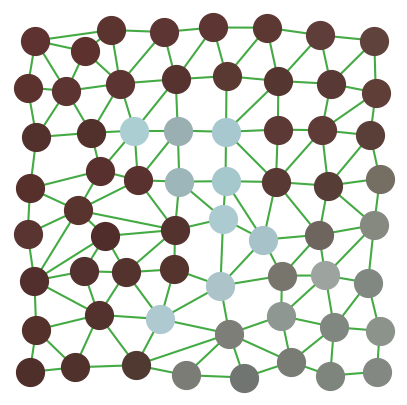

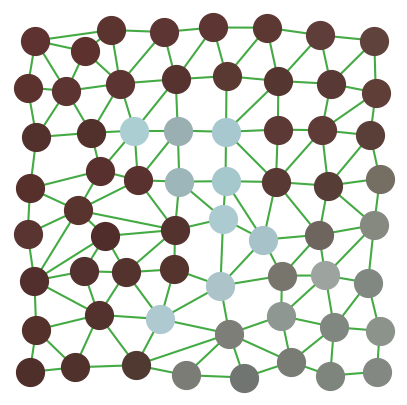

In [19]:
img_idx = 30

gg = dataset[img_idx]
draw_utils.draw_superpixel_from_graph(
    gg.pos, gg.x[:, 2:],
    gg.edge_index,
)
plt.show()

img_ori, lbl = ori_dataset[img_idx]
img_sp, segments, node2map = make_segments_and_graph(
    torch.permute(img_ori, (1, 2, 0)), channel_axis=2,
    compactness=0.1,
)
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2:],
    img_sp.edge_index,
)

In [20]:
# for img_idx in range(540, 580):
#     print('idx', img_idx)
#     img_ori, lbl = ori_dataset[img_idx]

#     # img_ori, lbl = MNISTM(ORIGIN_DATA_DIR, mode='train')[img_idx]
#     img_sp, segments, node2map = make_segments_and_graph(
#         torch.permute(img_ori / 255, (1, 2, 0)), channel_axis=2,
#     )
#     img_sp.y = torch.tensor(lbl)
    
#     img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
#     img_sp = img_sp.to(device)
#     print(lbl, model(img_sp).argmax(dim=1))
    
# #     if lbl != model(img_sp).argmax(dim=1).item():
# #         continue

#     img_smooths = [
#         mask_with_spgie(
#             img_ori, img_sp, segments, lbl,
#             alpha=0.33,
#         )
#     ]

#     for s1 in range(1, 9):
#         temp, nodes, ch = mask_with_spgie(
#             img_ori, img_sp, segments, lbl,
#             alpha=0.33,
#             return_nodes=True,
#             smooth=True,
#             smooth_thresholds=[s1 / 10, 0],
#         )
#         img_smooths.append(temp)

# #     draw_utils.show_original(np.concatenate(img_smooths, axis=2), width=30)

#     figures, axes = plt.subplots(1, len(img_smooths), figsize=(20, 20))
#     for i, ims in enumerate(img_smooths):
#         axes[i].imshow(np.transpose(ims, (1, 2, 0)))
#         axes[i].axis('off')
#         axes[i].title.set_text(i / 10)

#     plt.show()

# # draw_utils.show_original(temp)

# # imp = [[0, 0, 0] for _ in range(img_sp.x.shape[0])]
# # for n in nodes:
# #     imp[n][0] = 128

# # draw_utils.draw_superpixel_from_graph(
# #     img_sp.pos, [img_sp.x[:, 2:], imp],
# #     img_sp.edge_index,
# #     multi_graph=True,
# # )

In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2

def mask_with_cam(img_ori, lbl, alpha=0.3):
    target_layers = [cnn_model.layer4[-1]]
#     target_layer = cnn_model.conv2
    input_tensor = img_ori.unsqueeze(0).to(device2)
    cam = GradCAM(model=cnn_model, target_layers=target_layers, use_cuda=use_cuda)
    target_category = lbl

    targets = [ClassifierOutputTarget(lbl)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    img = np.transpose(img_ori, (1, 2, 0))
    mask = grayscale_cam
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    h = heatmap.mean(axis=2)
    img_cam = h * img_ori.numpy()
#     plt.imshow(np.transpose(img_cam, (1, 2, 0)))
#     plt.show()
    return img_cam

# mask_with_cam(img_ori, lbl)

In [22]:
# LIME CNN
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries


lime_cnn_explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm('slic',
     n_segments=75,
     multichannel=True,
     slic_zero=True, start_label=0
)

@torch.no_grad()
def batch_predict(img):
    global cnn_model
    img = np.transpose(img, (0, 3, 1, 2))
    img = torch.from_numpy(img).float().contiguous()
#         print('img', img.get_device())
#         print('cnn', next(cnn_model.parameters()).get_device())
    cnn_model = cnn_model.to(device2)
    output = cnn_model(img.to(device2))
    output = torch.nn.functional.softmax(output, dim=1)
    return output.cpu().numpy()

def mask_with_lime_cnn(img_ori, lbl, num_samples=50, alpha=0.3):
    global m, mask
    img_temp = img_ori.squeeze()
    img_temp = img_temp.double().cpu().numpy()

    explanation = lime_cnn_explainer.explain_instance(np.transpose(img_temp, (1, 2, 0)), 
                                             batch_predict, # classification function
                                             top_labels=5,
                                             hide_color=0, 
                                             num_samples=num_samples,
                                             segmentation_fn=segmenter,
#                                              progress_bar=False,
                                        ) # number of images that will be sent to classification function

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False, num_features=5,
                                                hide_rest=False)
#     conf_lime = torch.tensor(mask)
#     img_boundry1 = mark_boundaries(temp, mask)
    
    img_mask = mask * (1 - alpha) + (alpha)
    img_lime = img_mask * np.array(img_ori.squeeze())
    
    return img_lime

In [23]:
# LIME Graph
from lime_graph import LimeGraphExplainer
# from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

lime_graph_explainer = LimeGraphExplainer()
# segmenter = SegmentationAlgorithm('slic',
#      n_segments=75,
#      multichannel=True,
#      slic_zero=True, start_label=0
# )

@torch.no_grad()
def batch_predict_graph(graph):
    output = model(graph.to(device))
    output = torch.nn.functional.softmax(output, dim=1)
    return output.detach().cpu().numpy()

def mask_with_lime_graph(img_ori, img_g, segments, lbl, num_samples=50, alpha=0.3):
    global m, mask
    img_temp = img_ori.squeeze()
    img_temp = img_temp.double().cpu().numpy()
    
    n_segments = np.max(segments) + 1
    node2map = {n: (segments == n) for n in range(n_segments)}

# explain_instance(np.transpose(img_temp, (1, 2, 0)), 
#                                          graph,
#                                          node2map,
#                                          batch_predict, # classification function
#                                          top_labels=5,
#                                          hide_color=0, 
#                                          num_samples=200,
# #                                          segmentation_fn=segmenter,
#                                          segments=segments,
#                                     )
    
    explanation = lime_graph_explainer.explain_instance(np.transpose(img_temp, (1, 2, 0)),
                                             img_g,
                                             node2map,
                                             batch_predict_graph, # classification function
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=num_samples,
#                                              segmentation_fn=segmenter,
                                             segments=segments,
                                             progress_bar=False,
                                        ) # number of images that will be sent to classification function

    temp, mask = explanation.get_image_and_mask(lbl,
                                                positive_only=True,
                                                num_features=int(n_segments ** 0.5),
                                                hide_rest=False)
    
    img_mask = mask * (1 - alpha) + (alpha)
#     plt.imshow(img_mask)
#     plt.axis('off')
#     plt.show()
    img_lime = img_mask * np.array(img_ori.squeeze())
#     show_original(img_lime)
#     plt.show()
    
    return img_lime

# temp = mask_with_lime_SPGIE(img_ori, img_g, segments, lbl, num_samples=2000)
# plt.imshow(np.transpose(temp, (1, 2, 0)))

idx 170
idx 171
o tensor([7, 9, 8], device='cuda:1')
o tensor([7, 9, 2], device='cuda:1')
o tensor([1, 5, 3], device='cuda:1')
o tensor([1, 6, 2], device='cuda:1')
o tensor([1, 7, 3], device='cuda:1')
['99.1182%', '99.5017%', '2.4097%', '0.0524%', '4.8922%']
nnnnn 5


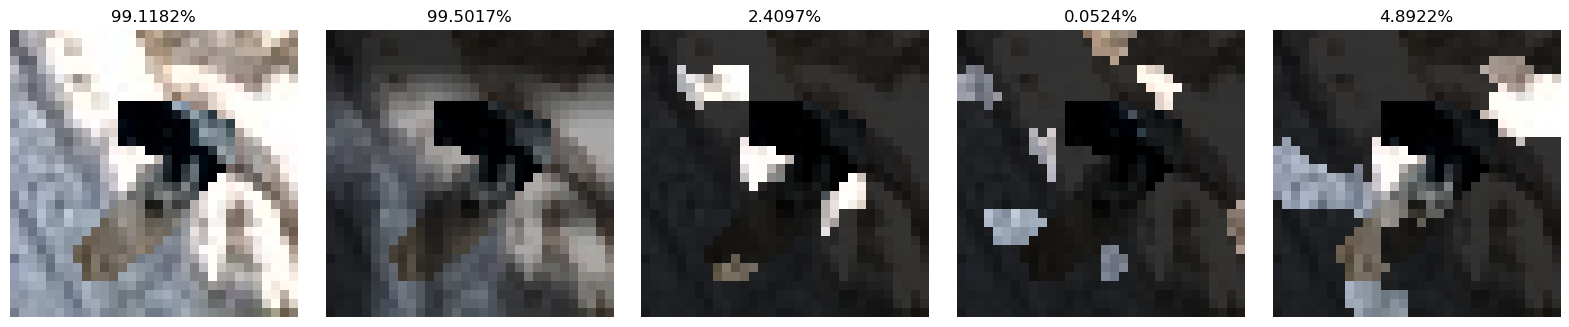

idx 172
idx 173
o tensor([3, 5, 8], device='cuda:1')
o tensor([3, 5, 8], device='cuda:1')
o tensor([3, 5, 7], device='cuda:1')
o tensor([9, 7, 5], device='cuda:1')
o tensor([3, 5, 9], device='cuda:1')
['100.0000%', '99.9999%', '72.4002%', '2.1005%', '99.7914%']
nnnnn 5


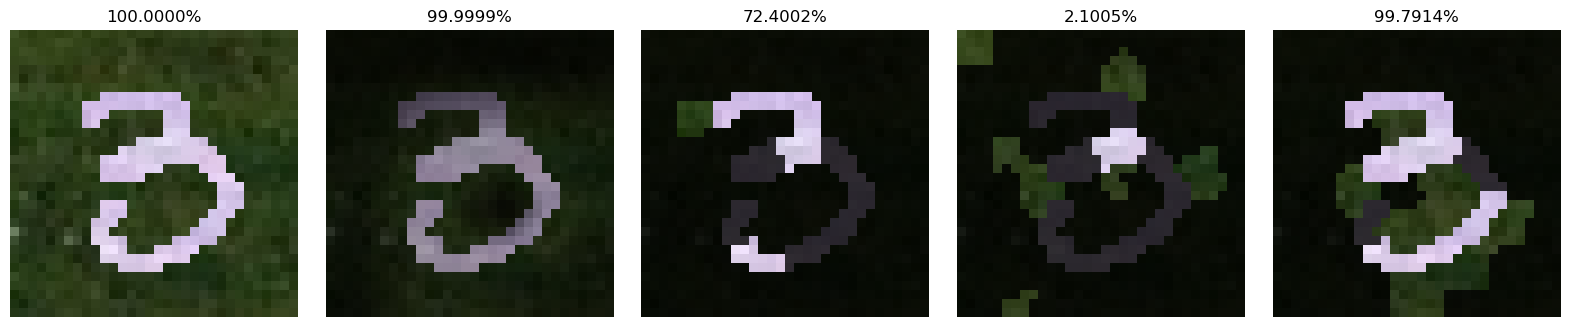

idx 174


In [24]:
for img_idx in range(170, 175):
    try:
        print('idx', img_idx)
        img_ori, lbl = ori_dataset[img_idx]
        # img_ori, lbl = MNISTM(ORIGIN_DATA_DIR, mode='train')[img_idx]
        img_sp, segments, node2map = make_segments_and_graph(
            torch.permute(img_ori / 255, (1, 2, 0)), channel_axis=2,
        )

        # for one amge
        alpha = 0.2
        num_samples = 200

        img_spgie = mask_with_spgie(img_ori, img_sp, segments, lbl, alpha=alpha)
        img_cam = mask_with_cam(img_ori, lbl)
        img_lime_cnn = mask_with_lime_cnn(
            img_ori, lbl,
            num_samples=num_samples, alpha=alpha,
        )
        img_lime_graph = mask_with_lime_graph(
            img_ori, img_sp, segments, lbl,
            num_samples=num_samples, alpha=alpha,
        )

        img_masks = [img_ori.numpy(), img_cam, img_lime_cnn, img_lime_graph, img_spgie]
        # img_masks = [img_ori.numpy(), img_spgie, img_cam]
        img_input = torch.cat([torch.from_numpy(im).unsqueeze(0).float() for im in img_masks], dim=0)
        #     print(img_masks.shape)
        img_input = img_input.to(device2)
        # print(img_input.device)
        out = cnn_model(img_input)
        out = torch.softmax(out, dim=1)
        for o in out:
            print('o', torch.topk(o, 3).indices)
        #     print('o', torch.topk(o, 3).values)

        scores = out[:, lbl].detach().tolist()
        socres = ['{:.4f}%'.format(s * 100) for s in scores]
        print(socres)

#         draw_utils.show_original(np.concatenate(img_masks, axis=2), width=20)

        print('nnnnn', len(img_masks))
        fig, axes = plt.subplots(1, len(img_masks), figsize=(20, 20), sharey=True)
        for i, ax in enumerate(axes):
            ax.imshow(np.transpose(img_masks[i], (1, 2, 0)))
            ax.axis('off')
            ax.set_title(socres[i])

        plt.subplots_adjust(wspace=0.1)
        plt.show()
    except:
        pass

## Profiler

In [25]:
from tqdm.auto import tqdm
import time

# == Profiler
# acc counter
# conf array
# explainer inference

# == loop
# timer
# img inference
# count acc

class Profiler:
    def __init__(self, num_samples, alpha):
        self.confs = []
        self.acc_count = 0
        self.running_time = 0.0
        
        self.num_samples = num_samples
        self.alpha = alpha
    
    def input_x(self, img_ori, lbl, img_g=None, segments=None):
        self.img_ori = img_ori
        self.img_g = img_g
        self.segments = segments
        self.lbl = lbl
    
    def mask_with_explainer(self, *args, **kwargs):
        raise NotImplementedError('Explainer method should be implemented.')
    
    def inference(self):
        t = time.time()
        res = self.mask_with_explainer()
        self.running_time += time.time() - t
        return res

class SPGIEProfiler(Profiler):
    @property
    def name(self):
        string = 'SPGIE'
        
        if self.smooth:
            string += ' sm({})'.format(self.smooth_thresholds)
        
        return string

    def __init__(self, num_samples, alpha, 
                 gx_threshold=1, counter_threshold=1,
                 smooth=False, smooth_thresholds=None,
                 *args, **kwargs,
    ):
        super().__init__(num_samples, alpha, *args, **kwargs)
        self.gx_threshold = gx_threshold
        self.counter_threshold = counter_threshold
        self.smooth = smooth
        self.smooth_thresholds = smooth_thresholds
        
    def mask_with_explainer(self):
        return mask_with_spgie(
            self.img_ori, self.img_g,
            self.segments, self.lbl,
            alpha=self.alpha,
            gx_threshold=self.gx_threshold, counter_threshold=self.counter_threshold,
            smooth=self.smooth, smooth_thresholds=self.smooth_thresholds,
        )
    
class GradCAMProfiler(Profiler):
    name = 'GradCAM'
    def mask_with_explainer(self):
        return mask_with_cam(
            self.img_ori, self.lbl,
            alpha=self.alpha,
        )

class LIMECNNProfiler(Profiler):
    name = 'LIME-CNN'
    def mask_with_explainer(self):
        return mask_with_lime_cnn(
            self.img_ori, self.lbl,
            num_samples=self.num_samples,
            alpha=self.alpha,
        )
    
class LIMEGraphProfiler(Profiler):
    name = 'LIME-Graph'
    def mask_with_explainer(self):
        return mask_with_lime_graph(
            self.img_ori, self.img_g,
            self.segments, self.lbl,
            num_samples=self.num_samples,
            alpha=self.alpha,
        )

In [26]:
import random

# max_size = len(test_ori_dset)
alpha = 0.2
num_samples = 50
# num_samples = 200
# num_samples = 500

rand_size = 50
# rand_size = 300
# rand_size = 1000
# rand_size = 3000
# rand_size = len(test_ori_dset)

rand_idx = random.sample(range(len(ori_dataset)), rand_size)

In [27]:
profilers = [
    SPGIEProfiler(num_samples, alpha),
#     SPGIEProfiler(num_samples, alpha, gx_threshold=2),
#     SPGIEProfiler(num_samples, alpha, counter_threshold=2),
    
#     SPGIEProfiler(num_samples, alpha, counter_threshold=2, smooth=True, smooth_thresholds=[0.3, 0.7]),
    
    GradCAMProfiler(num_samples, alpha),
    LIMECNNProfiler(num_samples, alpha),
    LIMEGraphProfiler(num_samples, alpha),
]

# for s1 in range(1, 7): # from 0.1 ~ 0.6
#     for s2 in range(6, 9): # from 0.6 ~ 0.8
#         profilers.append(
#             SPGIEProfiler(num_samples, alpha, counter_threshold=2,
#                           smooth=True, smooth_thresholds=[s1 / 10, s2 / 10]
#             ),
#         )

print(profilers)

t_cnn = 0.0
t_make_graph = 0.0

cnn_count = 0
confs_cnn = []


loader = tqdm(rand_idx, total=rand_size)
for idx in loader:
    t = time.time()
    img_ori, lbl = ori_dataset[idx]
    img_g, segments, _ = make_segments_and_graph(
        torch.permute(img_ori / 255, (1, 2, 0)), channel_axis=2,
    )
    t_make_graph = time.time() - t
#     segments = slic(np.transpose(img_ori, (1, 2, 0)), n_segments=75,
#                      multichannel=True,
#                      slic_zero=True, start_label=0,
#     )

    img_masks = [img_ori.numpy()]
    for p in profilers:
        p.input_x(img_ori, lbl, img_g, segments)

        try:
            img_masks.append(p.inference())
        except:
            pass
        
    img_input = torch.cat([torch.from_numpy(im).unsqueeze(0) for im in img_masks], dim=0)
    img_input = img_input.to(device2).float()
    t = time.time()
    out = cnn_model(img_input)
    t_cnn += time.time() - t
    out = torch.softmax(out, dim=1)
    
    confs = out[:, lbl].detach().tolist()
    confs_cnn.append(confs[0])
    if out[0, :].argmax(dim=0).item() == lbl:
        cnn_count += 1

    for i, p in enumerate(profilers):
        if i + 1 >= out.shape[0]:
            p.confs.append(None)
            continue
        if out[i + 1, :].argmax(dim=0).item() == lbl:
            p.acc_count += 1
        
        p.confs.append(confs[i + 1])

[<__main__.SPGIEProfiler object at 0x7f52c2427820>, <__main__.GradCAMProfiler object at 0x7f52c2425e10>, <__main__.LIMECNNProfiler object at 0x7f52c2426890>, <__main__.LIMEGraphProfiler object at 0x7f52c2426830>]


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


## Report

In [28]:
print('n_samples', num_samples, 'rand_size', rand_size)
for p in profilers:
    print(p.name, p.running_time)

print('CNN inference', t_cnn)

n_samples 50 rand_size 50
SPGIE 1.320732593536377
GradCAM 3.6933772563934326
LIME-CNN 8.360511779785156
LIME-Graph 8.205768346786499
CNN inference 0.7310302257537842


In [29]:
print('cnn\tacc:', cnn_count / len(confs_cnn))

for p in profilers:
    print(p.name, p.acc_count / len([c for c in p.confs if c != None]))

cnn	acc: 1.0
SPGIE 0.9
GradCAM 0.96
LIME-CNN 0.7
LIME-Graph 0.6190476190476191


In [30]:
def evaluation_count(confs_cnn, p):
    print(p.name)
    
    confs = np.array(p.confs)
    mask = confs != None
    confs = confs[mask]
    confs_cnn2 = np.array(confs_cnn)[mask]
    
    conf_diff = np.mean(confs - confs_cnn2)
    avg_increase = np.mean(confs > confs_cnn2) * 100
    drop_masked = confs < confs_cnn2
    avg_drop = np.mean(np.abs(confs[drop_masked] - confs_cnn2[drop_masked])) * 100
    
    print('Diff: {:.4f}\tTime: {:.2f}s\tAvgInc: {:5.2f}%\tAvgDrop: {:5.2f}%'.format(
        conf_diff, p.running_time, avg_increase, avg_drop,
    ))
    
for p in profilers:
    evaluation_count(confs_cnn, p)

SPGIE
Diff: -0.1017	Time: 1.32s	AvgInc: 12.00%	AvgDrop: 14.53%
GradCAM
Diff: -0.0835	Time: 3.69s	AvgInc:  8.00%	AvgDrop: 11.11%
LIME-CNN
Diff: -0.3445	Time: 8.36s	AvgInc:  4.00%	AvgDrop: 37.14%
LIME-Graph
Diff: -0.3937	Time: 8.21s	AvgInc:  4.76%	AvgDrop: 41.34%


In [31]:
# 1000 imgs
# SPGIE
# Diff: -0.0110	Time: 11.98s	AvgInc: 25.00%	AvgDrop:  2.62%
# SPGIE sm([0.3, 0.7])
# SPGIE sm([0.1, 0.6])
# Diff: -0.0187	Time: 12.96s	AvgInc: 21.50%	AvgDrop:  3.69%
# SPGIE sm([0.1, 0.7])
# Diff: -0.0222	Time: 12.97s	AvgInc: 19.60%	AvgDrop:  3.98%
# SPGIE sm([0.1, 0.8])
# Diff: -0.0384	Time: 12.91s	AvgInc: 15.70%	AvgDrop:  5.96%
# SPGIE sm([0.2, 0.6])
# Diff: -0.0196	Time: 12.94s	AvgInc: 20.80%	AvgDrop:  3.73%
# SPGIE sm([0.2, 0.7])
# Diff: -0.0233	Time: 12.93s	AvgInc: 19.30%	AvgDrop:  4.09%
# SPGIE sm([0.2, 0.8])
# Diff: -0.0401	Time: 12.87s	AvgInc: 15.80%	AvgDrop:  6.19%
# SPGIE sm([0.3, 0.6])
# Diff: -0.0244	Time: 12.79s	AvgInc: 18.80%	AvgDrop:  4.21%
# SPGIE sm([0.3, 0.7])
# Diff: -0.0278	Time: 12.81s	AvgInc: 17.50%	AvgDrop:  4.56%
# SPGIE sm([0.3, 0.8])
# Diff: -0.0457	Time: 12.78s	AvgInc: 14.40%	AvgDrop:  6.83%
# SPGIE sm([0.4, 0.6])
# Diff: -0.0316	Time: 12.68s	AvgInc: 17.00%	AvgDrop:  5.05%
# SPGIE sm([0.4, 0.7])
# Diff: -0.0350	Time: 12.69s	AvgInc: 16.30%	AvgDrop:  5.38%
# SPGIE sm([0.4, 0.8])
# Diff: -0.0530	Time: 12.67s	AvgInc: 14.20%	AvgDrop:  7.65%
# SPGIE sm([0.5, 0.6])
# Diff: -0.0480	Time: 12.53s	AvgInc: 14.70%	AvgDrop:  7.09%
# SPGIE sm([0.5, 0.7])
# Diff: -0.0510	Time: 12.51s	AvgInc: 14.20%	AvgDrop:  7.35%
# SPGIE sm([0.5, 0.8])
# Diff: -0.0681	Time: 12.48s	AvgInc: 12.40%	AvgDrop:  9.45%
# SPGIE sm([0.6, 0.6])
# Diff: -0.0705	Time: 12.36s	AvgInc: 12.10%	AvgDrop:  9.64%
# SPGIE sm([0.6, 0.7])
# Diff: -0.0741	Time: 12.35s	AvgInc: 12.10%	AvgDrop: 10.07%
# SPGIE sm([0.6, 0.8])
# Diff: -0.0877	Time: 12.34s	AvgInc: 11.20%	AvgDrop: 11.79%

In [32]:
# == 300 imgs
# seg 50
# SPGIE
# Diff: -0.0011	Time: 3.89s	AvgInc: 26.33%	AvgDrop:  0.88%
# GradCAM
# Diff: -0.0445	Time: 11.33s	AvgInc: 14.00%	AvgDrop:  6.96%
# LIME-CNN
# Diff: -0.1163	Time: 30.77s	AvgInc: 14.33%	AvgDrop: 15.09%
# LIME-Graph
# Diff: -0.1115	Time: 59.07s	AvgInc: 14.92%	AvgDrop: 15.23%

# == 1000 imgs
# SPGIE
# Diff: -0.0039	Time: 12.89s	AvgInc: 26.80%	AvgDrop:  1.28%
# GradCAM
# Diff: -0.0573	Time: 38.94s	AvgInc: 15.50%	AvgDrop:  8.44%

# -- 50 samples
# LIME-CNN
# Diff: -0.1415	Time: 101.97s	AvgInc: 11.00%	AvgDrop: 18.02%
# LIME-Graph
# Diff: -0.1369	Time: 198.34s	AvgInc: 10.91%	AvgDrop: 17.77%

# -- 200 samples
# LIME-CNN
# Diff: -0.0968	Time: 430.65s	AvgInc: 16.10%	AvgDrop: 13.95%
# LIME-Graph
# Diff: -0.0950	Time: 815.94s	AvgInc: 12.10%	AvgDrop: 13.07%

# -- 500 samples
# LIME-CNN
# Diff: -0.0753	Time: 945.91s	AvgInc: 18.10%	AvgDrop: 10.95%
# LIME-Graph
# Diff: -0.0630	Time: 2273.52s	AvgInc: 16.31%	AvgDrop:  9.56%

In [33]:
# metrics = '''SPGIE
# Diff: -0.0039	Time: 12.89s	AvgInc: 26.80%	AvgDrop:  1.28%
# GradCAM
# Diff: -0.0573	Time: 38.94s	AvgInc: 15.50%	AvgDrop:  8.44%
# LIME-CNN
# Diff: -0.1415	Time: 101.97s	AvgInc: 11.00%	AvgDrop: 18.02%
# LIME-Graph
# Diff: -0.1369	Time: 198.34s	AvgInc: 10.91%	AvgDrop: 17.77%
# LIME-CNN
# Diff: -0.0968	Time: 430.65s	AvgInc: 16.10%	AvgDrop: 13.95%
# LIME-Graph
# Diff: -0.0950	Time: 815.94s	AvgInc: 12.10%	AvgDrop: 13.07%
# LIME-CNN
# Diff: -0.0753	Time: 945.91s	AvgInc: 18.10%	AvgDrop: 10.95%
# LIME-Graph
# Diff: -0.0630	Time: 2273.52s	AvgInc: 16.31%	AvgDrop:  9.56%'''

In [34]:
metrics = '''SPGIE
Diff: -0.0110	Time: 11.98s	AvgInc: 25.00%	AvgDrop:  2.62%
SPGIE sm([0.1, 0.6])
Diff: -0.0187	Time: 12.96s	AvgInc: 21.50%	AvgDrop:  3.69%
SPGIE sm([0.1, 0.7])
Diff: -0.0222	Time: 12.97s	AvgInc: 19.60%	AvgDrop:  3.98%
SPGIE sm([0.1, 0.8])
Diff: -0.0384	Time: 12.91s	AvgInc: 15.70%	AvgDrop:  5.96%
SPGIE sm([0.2, 0.6])
Diff: -0.0196	Time: 12.94s	AvgInc: 20.80%	AvgDrop:  3.73%
SPGIE sm([0.2, 0.7])
Diff: -0.0233	Time: 12.93s	AvgInc: 19.30%	AvgDrop:  4.09%
SPGIE sm([0.2, 0.8])
Diff: -0.0401	Time: 12.87s	AvgInc: 15.80%	AvgDrop:  6.19%
SPGIE sm([0.3, 0.6])
Diff: -0.0244	Time: 12.79s	AvgInc: 18.80%	AvgDrop:  4.21%
SPGIE sm([0.3, 0.7])
Diff: -0.0278	Time: 12.81s	AvgInc: 17.50%	AvgDrop:  4.56%
SPGIE sm([0.3, 0.8])
Diff: -0.0457	Time: 12.78s	AvgInc: 14.40%	AvgDrop:  6.83%
SPGIE sm([0.4, 0.6])
Diff: -0.0316	Time: 12.68s	AvgInc: 17.00%	AvgDrop:  5.05%
SPGIE sm([0.4, 0.7])
Diff: -0.0350	Time: 12.69s	AvgInc: 16.30%	AvgDrop:  5.38%
SPGIE sm([0.4, 0.8])
Diff: -0.0530	Time: 12.67s	AvgInc: 14.20%	AvgDrop:  7.65%
SPGIE sm([0.5, 0.6])
Diff: -0.0480	Time: 12.53s	AvgInc: 14.70%	AvgDrop:  7.09%
SPGIE sm([0.5, 0.7])
Diff: -0.0510	Time: 12.51s	AvgInc: 14.20%	AvgDrop:  7.35%
SPGIE sm([0.5, 0.8])
Diff: -0.0681	Time: 12.48s	AvgInc: 12.40%	AvgDrop:  9.45%
SPGIE sm([0.6, 0.6])
Diff: -0.0705	Time: 12.36s	AvgInc: 12.10%	AvgDrop:  9.64%
SPGIE sm([0.6, 0.7])
Diff: -0.0741	Time: 12.35s	AvgInc: 12.10%	AvgDrop: 10.07%
SPGIE sm([0.6, 0.8])
Diff: -0.0877	Time: 12.34s	AvgInc: 11.20%	AvgDrop: 11.79%'''

In [35]:
header = 'Method,Diff,Time,AvgInc,AvgDrop\n'
ms = metrics.replace('\nDiff: ', ',')
ms = ms.replace('\tTime: ', ',').replace('\tAvgInc: ', ',').replace('\tAvgDrop: ', ',')
# ms = ms.split('\n')
print(header + ms)

# with open('faithfull_smooth.csv', 'w', encoding='utf-8') as f:
#     f.write(header + ms)

Method,Diff,Time,AvgInc,AvgDrop
SPGIE,-0.0110,11.98s,25.00%, 2.62%
SPGIE sm([0.1, 0.6]),-0.0187,12.96s,21.50%, 3.69%
SPGIE sm([0.1, 0.7]),-0.0222,12.97s,19.60%, 3.98%
SPGIE sm([0.1, 0.8]),-0.0384,12.91s,15.70%, 5.96%
SPGIE sm([0.2, 0.6]),-0.0196,12.94s,20.80%, 3.73%
SPGIE sm([0.2, 0.7]),-0.0233,12.93s,19.30%, 4.09%
SPGIE sm([0.2, 0.8]),-0.0401,12.87s,15.80%, 6.19%
SPGIE sm([0.3, 0.6]),-0.0244,12.79s,18.80%, 4.21%
SPGIE sm([0.3, 0.7]),-0.0278,12.81s,17.50%, 4.56%
SPGIE sm([0.3, 0.8]),-0.0457,12.78s,14.40%, 6.83%
SPGIE sm([0.4, 0.6]),-0.0316,12.68s,17.00%, 5.05%
SPGIE sm([0.4, 0.7]),-0.0350,12.69s,16.30%, 5.38%
SPGIE sm([0.4, 0.8]),-0.0530,12.67s,14.20%, 7.65%
SPGIE sm([0.5, 0.6]),-0.0480,12.53s,14.70%, 7.09%
SPGIE sm([0.5, 0.7]),-0.0510,12.51s,14.20%, 7.35%
SPGIE sm([0.5, 0.8]),-0.0681,12.48s,12.40%, 9.45%
SPGIE sm([0.6, 0.6]),-0.0705,12.36s,12.10%, 9.64%
SPGIE sm([0.6, 0.7]),-0.0741,12.35s,12.10%,10.07%
SPGIE sm([0.6, 0.8]),-0.0877,12.34s,11.20%,11.79%


In [36]:
smooth_m = metrics.split('\nSPGIE')[1:]
smooth_m = [
    {
        'l2': float(m[5:8]),
        'l1': float(m[10:13]),
        'increase': float(m[50:56]),
        'drop': float(m[66:-1]),
    }
    for m in smooth_m
]

In [37]:
fsize1 = 16
fsize2 = 8

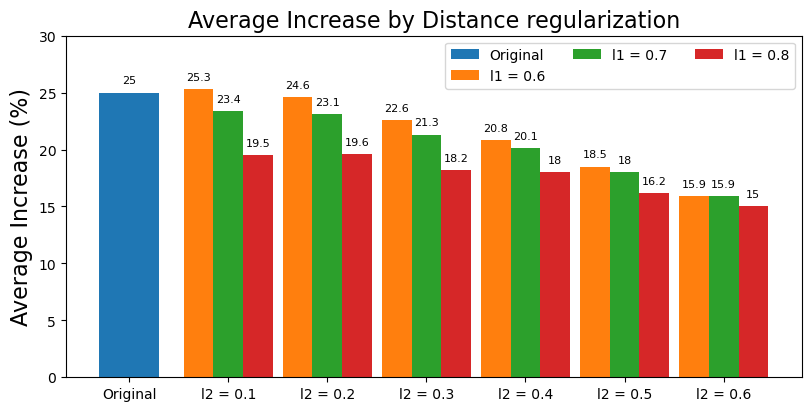

In [38]:
l2_params = [f'l2 = {i / 10}' for i in range(1, 7)]
original_increase = 25.00
original_drop = 2.62

smooth_increase = {
    f'l1 = {(i + 6) / 10}' : [m['increase'] + 3.8 for m in smooth_m[i::3]]
    for i in range(3)
}
smooth_drop = {
    f'l1 = {(i + 6) / 10}' : [m['drop'] for m in smooth_m[i::3]]
    for i in range(3)
}


x = np.arange(len(l2_params) + 1)  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

orig = ax.bar(width, original_increase, width*2, label='Original')
ax.bar_label(orig, padding=5, fontsize=fsize2)

for attribute, measurement in smooth_increase.items():
    offset = width * multiplier
    rects = ax.bar(x[1:] + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5, fontsize=fsize2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Increase (%)', fontsize=fsize1)
ax.set_title('Average Increase by Distance regularization', fontsize=fsize1)
ax.set_xticks(x + width, ['Original'] + l2_params, fontsize=fsize2 + 2)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 30)

plt.savefig('distance_regularization_inc.svg')
# plt.show()

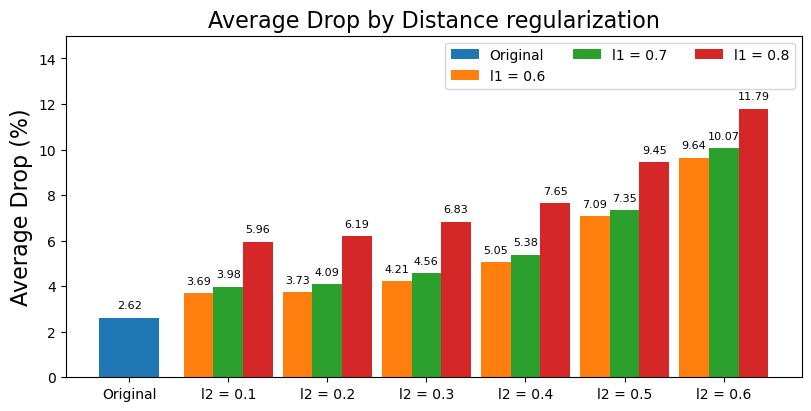

In [39]:
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

orig = ax.bar(width, original_drop, width*2, label='Original')
ax.bar_label(orig, padding=5, fontsize=fsize2)

for attribute, measurement in smooth_drop.items():
    offset = width * multiplier
    rects = ax.bar(x[1:] + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5, fontsize=fsize2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Drop (%)', fontsize=fsize1)
ax.set_title('Average Drop by Distance regularization', fontsize=fsize1)
ax.set_xticks(x + width, ['Original'] + l2_params, fontsize=fsize2 + 2)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 15)

plt.savefig('distance_regularization_drop.svg')
# plt.show()